In [1]:
import tensorflow as tf
import numpy as np
import gym
import matplotlib.pyplot as plt
from gym.envs.registration import register
import random

register(
    id='FrozenLake-v3',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name':'4x4',
           'is_slippery':True}
)

env = gym.make('FrozenLake-v3')

C:\Users\CSH\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [27]:
input_size = env.observation_space.n # 16
hidden_size = 50
output_size = env.action_space.n # 4

def one_hot(a):
    t=np.zeros(input_size)
    t[a]=1
    t = np.reshape(t,[1,input_size])
    return(t)

tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None,input_size])
w1 = tf.get_variable(shape=[input_size, hidden_size], name='w1', initializer=tf.contrib.layers.xavier_initializer())
w2 = tf.get_variable(shape=[hidden_size, output_size], name='w2', initializer=tf.contrib.layers.xavier_initializer())
y = tf.placeholder(tf.float32, shape=[None,output_size])

layer1 = tf.matmul(x,w1)
layer1 = tf.nn.tanh(layer1)
Qpred = tf.matmul(layer1,w2)
loss = tf.reduce_mean(tf.square(y-Qpred))
train = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)

n_episode=1000
dis = 0.9
rList=[]

In [28]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [29]:
for episode in range(n_episode):
    state =env.reset() # env.reset하면 자기 현재 state가 0으로 돌아감 
    done = False
    e = 1/(10 + episode/50)
    while not done:
        Qs = sess.run(Qpred, feed_dict={x:one_hot(state)})
        action = np.argmax(Qs)
        if np.random.rand(1) < e:
            action = np.random.choice(output_size,1)[0]
        new_state, reward, done, _ = env.step(action)
        if not done:
            Qs[0, action] = reward + dis*np.max(sess.run(Qpred, feed_dict={x:one_hot(new_state)}))
        else:
            Qs[0,action] = reward
        sess.run(train, feed_dict={x:one_hot(state), y:Qs})    
        state=new_state
    rList.append(reward)
    if episode %200 ==0:
        print(sess.run(loss, feed_dict={x:one_hot(state), y:Qs}))

0.23032345
0.018810771
0.11974033
0.10643339
0.12272897


In [30]:
sum(rList)

218.0

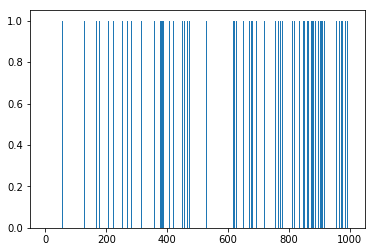

In [31]:
plt.bar(range(len(rList)), rList)
plt.show()

### Repository

In [44]:
input_size = env.observation_space.n # 16
hidden_size = 50
output_size = env.action_space.n # 4

def one_hot(a):
    t=np.zeros(input_size)
    t[a]=1
    t = np.reshape(t,[1,input_size])
    return(t)

tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None,input_size])
w1 = tf.get_variable(shape=[input_size, hidden_size], name='w1', initializer=tf.contrib.layers.xavier_initializer())
w2 = tf.get_variable(shape=[hidden_size, output_size], name='w2', initializer=tf.contrib.layers.xavier_initializer())
y = tf.placeholder(tf.float32, shape=[None,output_size])

layer1 = tf.matmul(x,w1)
layer1 = tf.nn.tanh(layer1)
Qpred = tf.matmul(layer1,w2)
loss = tf.reduce_mean(tf.square(y-Qpred))
train = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)

n_episode=3000
dis = 0.9
rList=[]
repository=[]

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for episode in range(n_episode):
    state =env.reset() # env.reset하면 자기 현재 state가 0으로 돌아감 
    done = False
    e = 1/(10 + episode/50)
    while not done:
        Qs = sess.run(Qpred, feed_dict={x:one_hot(state)})
        action = np.argmax(Qs)
        if np.random.rand(1) < e:
            action = np.random.choice(output_size,1)[0]
        new_state, reward, done, _ = env.step(action)
        repository.append((state, action, new_state, reward, done))
        state=new_state
        
    if episode%10==1:
        
        for _ in range(50):
            x_stack = np.empty(0).reshape(0, input_size)
            y_stack = np.empty(0).reshape(0, output_size) # x_stack, y_stack 초기화가 여기잇어야돼지안나? 이 for문 위에 잇는건 좀말이안댐 
            groups = random.sample(repository,10)           # 여기잇는거 맞다 
            for group in groups:
                state, action, new_state, reward, done = group
                Qs = sess.run(Qpred, feed_dict={x:one_hot(state)})
                if not done:
                    Qs[0,action] = reward + dis* np.max(sess.run(Qpred, feed_dict={x:one_hot(new_state)}))
                else:
                    Qs[0,action] = reward
                x_stack = np.vstack([x_stack, one_hot(state)]) # state를 넣으면 update된 qs값이 나오도록 network를 학습하자 ! 
                y_stack = np.vstack([y_stack, Qs])
            sess.run(train, feed_dict={x:x_stack, y:y_stack})     
    rList.append(reward)
    if episode %200 ==0:
        print(sess.run(loss, feed_dict={x:one_hot(state), y:Qs}))

0.04012757
0.061462782
0.024506068
0.020722842
0.008266528
0.019398
0.052491076
0.061832875
0.018118264
0.05117269
0.025225146
0.01710534
0.017124416
0.01749167
0.053027228


In [45]:
sum(rList)

219.0

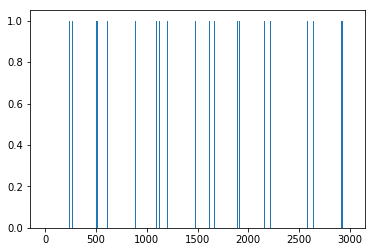

In [46]:
plt.bar(range(len(rList)), rList)
plt.show()